**XCeption DL modeling on COVID-QU-Ex**

In [4]:
import numpy as np
import pandas as pd
import cv2
import os

from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn import metrics

In [5]:
# This cells is made to set the different directories used in this notebook
groups = ['COVID-19', 'Normal', 'Non-COVID']
sets = ['Val', 'Test', 'Train']
# Define base path
base_path = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data' #Chemin jusqu'aux dossiers Test Train Val
destination_path = '/kaggle/working/COVID-EX-Qu-dataset'

In [6]:
# # Only run this cell if working files are not in kaggle working directory
# import shutil

# for sett in sets:
#   for group in groups:
#     ima_dir = os.path.join(base_path, sett, group)
#     for dos in tqdm(os.listdir(ima_dir)):
#         if dos=="images":
#             shutil.copytree(os.path.join(ima_dir, dos), os.path.join(destination_path, sett, group, dos))

In [7]:
# Checking data integrity after Kaggle input to output directory
n_covid = 0
n_noncovid = 0
n_normal = 0
#----Reference number from COVID-EX-qu Kaggle------------
ref_covid = 11956
ref_noncovid = 11263
ref_normal = 10701
#-------------------------------------------------------
for sett in sets:
  for group in groups:
    ima_dir = os.path.join(destination_path, sett, group)
    for dos in os.listdir(ima_dir):
      num = len(os.listdir(os.path.join(ima_dir, dos)))
      print(f"In the set {sett}, there are {num} {dos} of {group}")
      if group =="COVID-19" and dos=='images':
        n_covid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Non-COVID" and dos=='images':
        n_noncovid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Normal" and dos=='images':
        n_normal += len(os.listdir(os.path.join(ima_dir, dos)))

print(f"\nThere are {n_covid} COVID images found, {n_covid/ref_covid *100}% of the original dataset from Kaggle.")
print(f"There are {n_noncovid} non-COVID images, {n_noncovid/ref_noncovid *100}% of the original dataset from Kaggle.")
print(f"There are {n_normal} normal images, {n_normal/ref_normal *100}% of the original dataset from Kaggle.")

In the set Val, there are 1903 images of COVID-19
In the set Val, there are 1712 images of Normal
In the set Val, there are 1802 images of Non-COVID
In the set Test, there are 2395 images of COVID-19
In the set Test, there are 2140 images of Normal
In the set Test, there are 2253 images of Non-COVID
In the set Train, there are 7658 images of COVID-19
In the set Train, there are 6849 images of Normal
In the set Train, there are 7208 images of Non-COVID

There are 11956 COVID images found, 100.0% of the original dataset from Kaggle.
There are 11263 non-COVID images, 100.0% of the original dataset from Kaggle.
There are 10701 normal images, 100.0% of the original dataset from Kaggle.


In [8]:
# Checking if GPU is activated
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
from tensorflow.keras.applications.xception import preprocess_input # Preprocess for XCeption model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img):
    '''This function normalizes images by equalizing histograms (grayscale only)'''
    
    # Convert image to grayscale if it's not already
    if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Ensure image is of type uint8
    img = img.astype('uint8')
    # Equalize histogram
    img = cv2.equalizeHist(img)
    # Convert grayscale back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Preprocess for the model input
    img_preprocessed = preprocess_input(img)
    return img_preprocessed


# Instanciation of image data generators using the preprocessing function defined before

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image) 
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)

In [10]:
# Preprocessing of each folder

batch_size = 32
train_generator = train_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Train'),
                                                           class_mode="sparse",
                                                           target_size=(299, 299),
                                                           batch_size=batch_size)

val_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Val'),
                                                         class_mode="sparse",
                                                         target_size=(299, 299),
                                                         batch_size=batch_size)

test_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Test'),
                                                          class_mode="sparse",
                                                          target_size=(299, 299),
                                                          batch_size=batch_size, shuffle=False)

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


**XCeption Model**

In [11]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
    
# Initializing Xception model with pre-trained weights, without the specific top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freezing 
for layer in base_model.layers: 
    layer.trainable = False

# Add final layers to the model
XCeption_model = Sequential()
XCeption_model.add(base_model)
XCeption_model.add(GlobalAveragePooling2D())
XCeption_model.add(Dense(1024, activation='relu')) # Classification
XCeption_model.add(Dropout(rate=0.2)) # Help prevent overfitting
XCeption_model.add(Dense(512, activation='relu')) # Final lassification
XCeption_model.add(Dropout(rate=0.2)) # Help prevent overfitting
XCeption_model.add(Dense(3, activation='softmax'))  # 3 classes at the end even though we are looking for 2

# Model compilation
XCeption_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [12]:
# Sample size:
nb_img_train = train_generator.samples
nb_img_val = val_generator.samples

# Fit the model using the generator for training data
history_base_Xception = XCeption_model.fit(train_generator,
                                           steps_per_epoch=nb_img_train//batch_size,
                                           epochs=10,
                                           validation_data=val_generator,
                                           validation_steps=nb_img_val//batch_size)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/678 ━━━━━━━━━━━━━━━━━━━━ 4:10:35 22s/step - accuracy: 0.5312 - loss: 1.0401

I0000 00:00:1714668995.317843    2085 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/678 ━━━━━━━━━━━━━━━━━━━━ 2:17 247ms/step - accuracy: 0.6134 - loss: 0.8974

W0000 00:00:1714669024.630821    2086 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 155s 197ms/step - accuracy: 0.7182 - loss: 0.6739 - val_accuracy: 0.8317 - val_loss: 0.4299
Epoch 2/10
  1/678 ━━━━━━━━━━━━━━━━━━━━ 1:20 118ms/step - accuracy: 0.8125 - loss: 0.4340

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8125 - loss: 0.4340 - val_accuracy: 0.7778 - val_loss: 0.9013
Epoch 3/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 160s 168ms/step - accuracy: 0.8111 - loss: 0.4671 - val_accuracy: 0.8439 - val_loss: 0.4034
Epoch 4/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - accuracy: 0.8438 - loss: 0.4591 - val_accuracy: 0.7778 - val_loss: 0.8271
Epoch 5/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 114s 167ms/step - accuracy: 0.8325 - loss: 0.4185 - val_accuracy: 0.8412 - val_loss: 0.4080
Epoch 6/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - accuracy: 0.7500 - loss: 0.5040 - val_accuracy: 0.7778 - val_loss: 0.4065
Epoch 7/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 114s 166ms/step - accuracy: 0.8365 - loss: 0.3986 - val_accuracy: 0.8624 - val_loss: 0.3618
Epoch 8/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.8750 - loss: 0.3197 - val_accuracy: 0.8889 - val_loss: 0.2704
Epoch 9/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 114s 166ms/step - accuracy: 0.8469 - loss: 0.3734 - val_accu

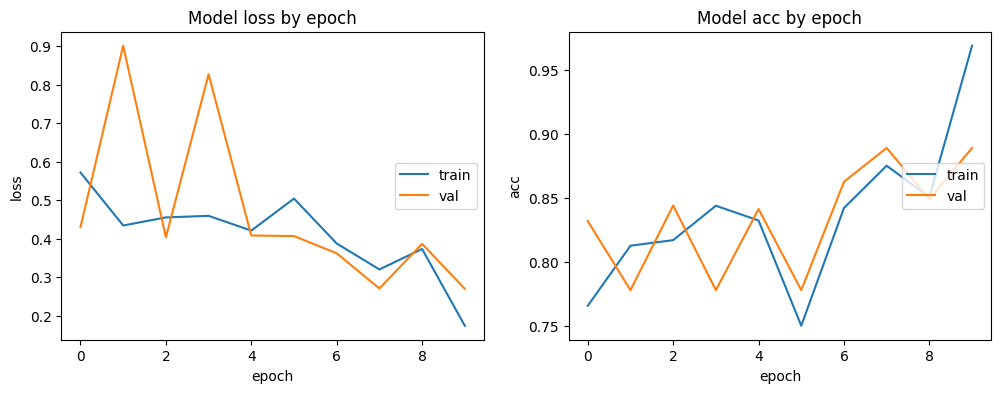

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_base_Xception.history['loss'])
plt.plot(history_base_Xception.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_base_Xception.history['accuracy'])
plt.plot(history_base_Xception.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [14]:
evaluation_base = XCeption_model.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation_base[0])
print("Test Accuracy:", evaluation_base[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 32s 151ms/step - accuracy: 0.8918 - loss: 0.2714
Test Loss: 0.3519657850265503
Test Accuracy: 0.8612256646156311


Base model is not very accurate, need to optimize it

In [15]:
def build_model(hp):
    # Initializing Xception model with pre-trained weights, without the specific top layers
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    
    # Freezing
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model on top
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),  
        Dense(128, activation='relu'),
        Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),  
        Dense(3, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [16]:
from  keras_tuner import RandomSearch
from  keras_tuner import HyperParameters
from tensorflow.keras.optimizers import Adam

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # optimize for validation accuracy
    max_trials=3,  # try 3 different hyperparameter combinations
    executions_per_trial=1,  
    directory='/kaggle/working/COVID-EX-Qu-dataset',  # directory to save logs and checkpoints
    project_name='Xception_tuning'  # name of the project
)
tuner.search_space_summary()

Search space summary
Default search space size: 2
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [17]:
tuner.search(train_generator,
             epochs=5,  
             validation_data=val_generator)

Trial 3 Complete [00h 09m 41s]
val_accuracy: 0.8573011159896851

Best val_accuracy So Far: 0.8573011159896851
Total elapsed time: 00h 29m 46s


In [18]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal dropout rate 1 is {best_hps.get('dropout_1')}.
The optimal dropout rate 2 is {best_hps.get('dropout_2')}.
""")


The optimal dropout rate 1 is 0.30000000000000004.
The optimal dropout rate 2 is 0.4.



In [19]:
# Build the model with the best hyperparameters
best_model_Xception = tuner.hypermodel.build(best_hps)

In [20]:
nb_img_train = train_generator.samples
nb_img_val = val_generator.samples
history_base_Xception_best = best_model_Xception.fit(train_generator, 
                                epochs = 10,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data=val_generator,
                                validation_steps=nb_img_val//batch_size
                                )

Epoch 1/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 128s 173ms/step - accuracy: 0.6899 - loss: 0.7072 - val_accuracy: 0.8249 - val_loss: 0.4419
Epoch 2/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7188 - loss: 0.6395 - val_accuracy: 0.6667 - val_loss: 0.5627
Epoch 3/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 111s 163ms/step - accuracy: 0.7985 - loss: 0.5008 - val_accuracy: 0.8491 - val_loss: 0.3937
Epoch 4/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 79us/step - accuracy: 0.7812 - loss: 0.6238 - val_accuracy: 0.7778 - val_loss: 0.3803
Epoch 5/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 112s 163ms/step - accuracy: 0.8172 - loss: 0.4554 - val_accuracy: 0.8410 - val_loss: 0.4119
Epoch 6/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - accuracy: 0.7812 - loss: 0.5747 - val_accuracy: 0.7778 - val_loss: 0.3943
Epoch 7/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 114s 167ms/step - accuracy: 0.8265 - loss: 0.4330 - val_accuracy: 0.8491 - val_loss: 0.3961
Epoch 8/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 79us/step - accuracy: 0.8438 - loss: 0.4898

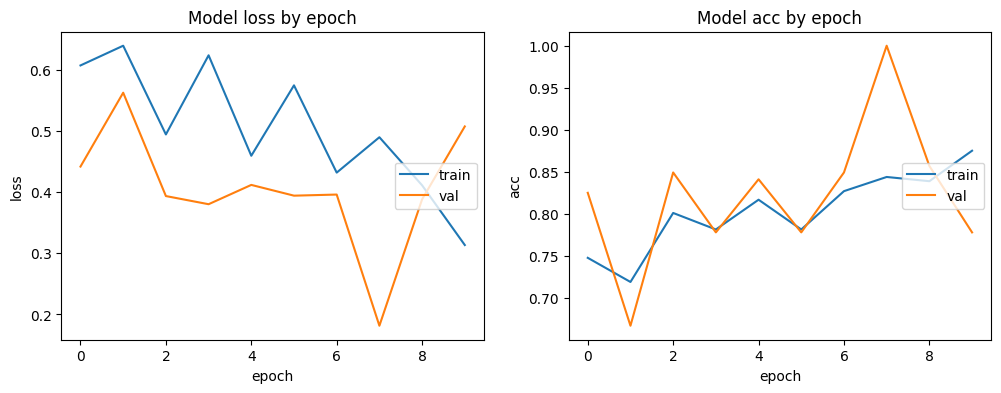

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_base_Xception_best.history['loss'])
plt.plot(history_base_Xception_best.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_base_Xception_best.history['accuracy'])
plt.plot(history_base_Xception_best.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [22]:
evaluation_base_best = best_model_Xception.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation_base_best[0])
print("Test Accuracy:", evaluation_base_best[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 31s 143ms/step - accuracy: 0.8900 - loss: 0.2782
Test Loss: 0.3665838837623596
Test Accuracy: 0.864319384098053


In [23]:
best_model_Xception.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,534,963 (85.96 MB)

 Trainable params: 557,827 (2.13 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 1,115,656 (4.26 MB)

**Unfreezing**

In [24]:
model_layers_count = len(best_model_Xception.layers)
print("Number of layers in the model (base_model counts for 1 layer): ", model_layers_count)

Number of layers in the model (base_model counts for 1 layer):  7


In [25]:
base_model_layers_count = len(best_model_Xception.layers[0].layers)
print("Number of layers in the base model: ", base_model_layers_count)

Number of layers in the base model:  132


In [26]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [27]:
print('First layer of the middle flow:', base_model.layers[36])
print('Middle flow start of the 2nd loop', base_model.layers[46])
print('Middle flow start of the 3rd loop', base_model.layers[56])
print('First layer of the exit flow', base_model.layers[116])
# https://arxiv.org/pdf/1610.02357
# Unfreezing from the start of the Middle flow, will be reduced if it is too long

First layer of the middle flow: <Activation name=block5_sepconv1_act, built=True>
Middle flow start of the 2nd loop <Activation name=block6_sepconv1_act, built=True>
Middle flow start of the 3rd loop <Activation name=block7_sepconv1_act, built=True>
First layer of the exit flow <Activation name=block13_sepconv1_act, built=True>


In [28]:
for layer in best_model_Xception.layers[0].layers[36:]:
    layer.trainable = True

In [29]:
from tensorflow.keras.optimizers import Adam
best_model_Xception.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nb_img_train = train_generator.samples
nb_img_val = val_generator.samples

In [30]:
history_Xception_unfrozen = best_model_Xception.fit(train_generator, 
                                epochs = 10,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data=val_generator,
                                validation_steps=nb_img_val//batch_size
                                )

Epoch 1/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 286s 362ms/step - accuracy: 0.8342 - loss: 0.4506 - val_accuracy: 0.9279 - val_loss: 0.1938
Epoch 2/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9062 - loss: 0.2926 - val_accuracy: 0.8889 - val_loss: 0.4228
Epoch 3/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 224s 329ms/step - accuracy: 0.9445 - loss: 0.1477 - val_accuracy: 0.9329 - val_loss: 0.1903
Epoch 4/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 91us/step - accuracy: 0.8750 - loss: 0.2644 - val_accuracy: 1.0000 - val_loss: 0.0133
Epoch 5/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 224s 329ms/step - accuracy: 0.9654 - loss: 0.0970 - val_accuracy: 0.9079 - val_loss: 0.2826
Epoch 6/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 88us/step - accuracy: 0.9688 - loss: 0.1011 - val_accuracy: 1.0000 - val_loss: 0.0670
Epoch 7/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 224s 329ms/step - accuracy: 0.9816 - loss: 0.0537 - val_accuracy: 0.9299 - val_loss: 0.2470
Epoch 8/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.9375 - loss: 0.1990

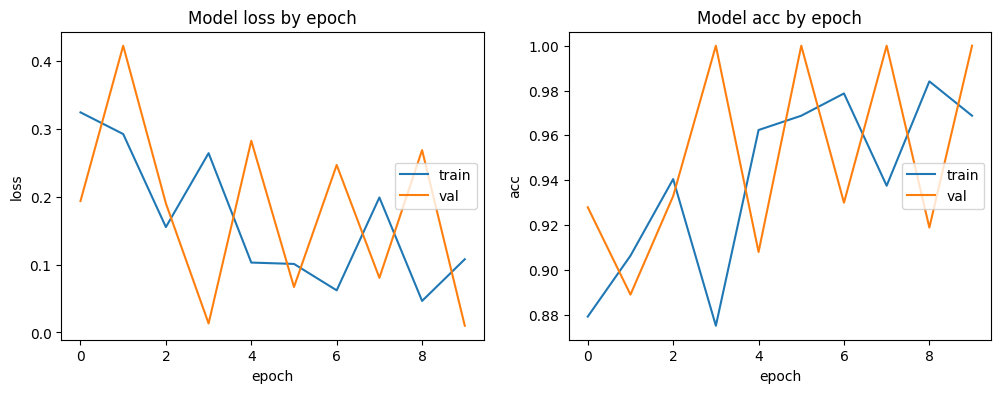

In [31]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_Xception_unfrozen.history['loss'])
plt.plot(history_Xception_unfrozen.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_Xception_unfrozen.history['accuracy'])
plt.plot(history_Xception_unfrozen.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [33]:
evaluation_unfrozen = best_model_Xception.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation_unfrozen[0])
print("Test Accuracy:", evaluation_unfrozen[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 27s 128ms/step - accuracy: 0.9476 - loss: 0.1957
Test Loss: 0.20170657336711884
Test Accuracy: 0.9409251809120178
